In [1]:
import sys
import os
import numpy as np
from osgeo import ogr 
from collections import deque
import matplotlib.pyplot as plt

from growingline import *

sys.path.append("/home/riannek/code/gleis/gleisachse")
from algs.gpkg import * 

ogr.UseExceptions()

In [2]:
ds = None 


In [3]:
layer_name = "viele"

folder = "/media/riannek/minimax/gleis/"

ds = None 

import shutil 
file = shutil.copyfile(os.path.join(folder, "stage3vers.gpkg"), os.path.join(folder, "stage3tmp_ohne.gpkg"))

ds = ogr.Open(file, 1)

layers = []
for i in range(ds.GetLayerCount()):
    layer = ds.GetLayer(i)
    layers.append(layer.GetName())
layers.sort()
print(layers)

layer = ds.GetLayerByName(layer_name)

['TEMPLINELAYER', 'abseits', 'anfang weiche', 'kurve', 'viele', 'viele1', 'weiche']


In [4]:
def new_line_layer(ds, spatial_reference, logger):
    if layer_exists(ds, "centerlines"):
        delete_layer(ds, "centerlines", logger)
    layer = ds.CreateLayer("centerlines", spatial_reference, ogr.wkbLineString25D)
    return layer 


linelayer = new_line_layer(ds, layer.GetSpatialRef(), None)

def linelayer_add(layer, geom):
    feature = ogr.Feature(layer.GetLayerDefn())
    feature.SetGeometry(geom)
    layer.CreateFeature(feature)


In [5]:
def get_all_points(layer):
    """Get all points from the layer as a list of numpy arrays"""
    points = []
    for feature in layer:
        geom = feature.GetGeometryRef()
        if geom is None:
            continue
        for i in range(geom.GetPointCount()):
            point = np.array(geom.GetPoint(i)[:3])
            points.append(point)

    layer.ResetReading()
    return np.array(points)

In [6]:
queue = deque()

In [7]:
all_points = get_all_points(layer)

In [8]:

layer.GetFeatureCount()

12549

## Start

In [34]:
layer.ResetReading()

In [38]:
feature = layer.GetNextFeature()
feature


OGRFeature(viele):2033
  eig x (Real) = 0.993672846701168
  eig y (Real) = 0.112232478025178
  eig z (Real) = -0.00425964847443124
  gauge (Real) = 1.43642164017269
  min points (Integer) = 395
  POINT Z (4481144.91488091 5356994.23314815 451.871829389971)


In [36]:
feature = layer.GetFeature(2033) 
feature  

OGRFeature(viele):2033
  eig x (Real) = 0.993672846701168
  eig y (Real) = 0.112232478025178
  eig z (Real) = -0.00425964847443124
  gauge (Real) = 1.43642164017269
  min points (Integer) = 395
  POINT Z (4481144.91488091 5356994.23314815 451.871829389971)


In [11]:
active_line = GrowingLine.from_feature(feature)


In [12]:
first_fid = None
first_xyz = None 
first_direction = None
first_iteration = True

## Ab hier muss dann Schleife

In [19]:
print("Current starting point:", feature.GetFID())
xyz, directions, fids = active_line.points_in_direction(layer)
print(len(xyz), "Points in direction")

if len(xyz) < 3:
    remove_points(fids, layer)
    if active_line.in_switch:
        active_line.make_cut(first_fid, first_xyz, first_direction)
    not_finished = active_line.reverse_head()
    if not_finished is False:
        queue.extend(active_line.switch)
        print(len(queue), "in queue")
        active_line = queue.pop()

Current starting point: 2031
164 Points in direction


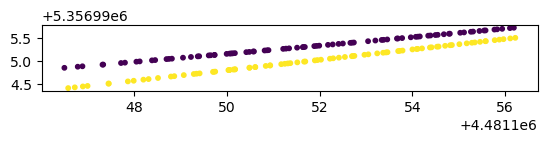

In [20]:
labels = ransac_lines(xyz, threshold=0.05, max_iterations=20)
max_label = labels.max()

x = xyz[:, 0]
y = xyz[:, 1]

fig, ax = plt.subplots()
sc = ax.scatter(x, y, c=labels, cmap='viridis', s=10)
# plt.colorbar(sc)
#equal aspect ratio
ax.set_aspect('equal', adjustable='box')


In [21]:
# If the start point is in a switch, it causes all kinds of problems 
if first_iteration and max_label > 0:
    # Create another line and stop here
    feature = layer.GetNextFeature()
    active_line = GrowingLine.from_feature(feature)
    first_iteration = True
    raise StartInSwitchError
first_iteration = False

StartInSwitchError: Start point is in a switch, prone to bugs.

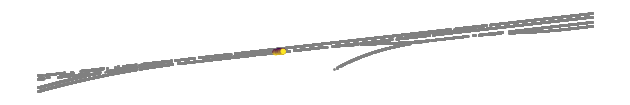

In [ ]:
fig, ax = plt.subplots()
ax.scatter(all_points[:, 0], all_points[:, 1], c='gray', s=1)
ax.scatter(x, y, c=labels, cmap='viridis', s=10)
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()
fig.tight_layout()
fig.savefig("current_ransac_lines.png", dpi=300, bbox_inches='tight', pad_inches=0)

In [ ]:
remove_points(fids[labels == -1], layer)

In [ ]:
# Check if we reached the end of a switch
if active_line.in_switch and labels.max() == 0:
    print("CUT")

    active_line.make_cut(first_fid, first_xyz, first_direction)
    if not active_line.reverse_head():
        # If we can't reverse the head, we are done
        print("Finished growing line")
        queue.extend(active_line.switch)
        print(len(queue), "in queue")
        active_line = queue.pop()

else:
    for label in range(labels.max()+1):
        cluster = xyz[labels == label]
        if len(cluster) < 2:
            continue

        
        fids_cluster = fids[labels == label]
        directions_cluster = directions[labels == label]
        



        if label == labels[0]:
            # This is the active head 
            pruned, offset = pruned_points(cluster)
            remove_points(fids_cluster[:offset+1], layer)

            new_direction = directions_cluster[offset]
            if active_line.head_direction @ new_direction < 0:
                new_direction = -new_direction

            active_line.head_xyz = pruned[-1]
            active_line.head_direction = new_direction
            active_line.head_fid = fids_cluster[offset]

            if np.array_equal(pruned[0], active_line.points[-1]):
                # Remove the first point if it is already in the line
                pruned = pruned[1:]  
            
            active_line.points.extend(pruned) 
            print(len(pruned), "points added to active line")
        else:
            # This is the other rail in a switch (or false positive)
            active_line.add_switch(fids_cluster[-1], cluster[-1], directions_cluster[-1])

            first_fid = fids_cluster[0]
            first_xyz = cluster[0]
            first_direction = directions_cluster[0]



Adding new switch line
11 points added to active line


In [ ]:
print("active line points:", len(active_line.points))
print("switch lines:", len(active_line.switch))
for i, switch in enumerate(active_line.switch):
    print(f"Switch line {i} points:", len(switch.points), "norm", np.linalg.norm(switch.head_xyz - switch.start_xyz)) 

active line points: 12
switch lines: 1
Switch line 0 points: 1 norm 0.0


In [ ]:
active_line.switch

[GrowingLine(id=1, head_fid=10231, points=1)]

(5356993.1651445385, 5356996.661223914)

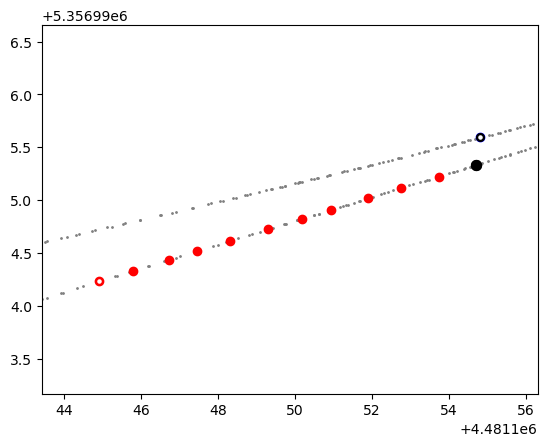

In [ ]:
fig, ax = plt.subplots()


active = np.array(active_line.points) 

ax.scatter(active[:, 0], active[:, 1], c='red')
ax.scatter(active_line.head_xyz[0], active_line.head_xyz[1], c='black', s=50, label='Head')

colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink']

for i, switch in enumerate(active_line.switch):
    points = np.array(switch.points)
    ax.scatter(points[:, 0], points[:, 1], c=colors[i % len(colors)])
    ax.scatter(switch.head_xyz[0], switch.head_xyz[1], c='black', s=30, label='Head')
    if switch.start_fid is not None:
        ax.scatter(switch.start_xyz[0], switch.start_xyz[1], c='white', s=5)

ax.scatter(active_line.head_xyz[0], active_line.head_xyz[1], c='black', s=50, label='Head')
if active_line.start_fid is not None:
    ax.scatter(active_line.start_xyz[0], active_line.start_xyz[1], c='white', s=5)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

x_lim = (x_lim[0] - 1, x_lim[1] + 1)
y_lim = (y_lim[0] - 1, y_lim[1] + 1)

ax.scatter(all_points[:, 0], all_points[:, 1], c='gray', s=1, zorder=0)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
#ax.set_aspect('equal', adjustable='box')

## STOP HERE

In [ ]:
raise ValueError("Stop here")

ValueError: Stop here

In [ ]:
active_line.reverse_head()

In [ ]:
queue.extend(active_line.switch)
print(len(queue))
active_line = queue.pop()

In [ ]:
geom = active_line.get_linestring()
print(geom.Length())

if geom.Length() > 5:
    linelayer_add(linelayer, geom)


In [ ]:
ds = None

In [ ]:
print(len(active_line.switch))

In [ ]:
active_line.points

In [ ]:
active_line.head_fid

In [ ]:
active_line.head_xyz

In [ ]:
active_line.switch 

In [ ]:
active_line.switch[0].head_fid  

In [ ]:
active_line.switch[1].head_fid  

In [ ]:
foo = np.array(active_line.points)
foo = foo[:,1] 
x = np.arange(len(foo))
fig, ax = plt.subplots()
ax.plot(x, foo)

In [ ]:
fig, ax = plt.subplots()
foo = np.array(active_line.points)
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='b', s=1)

foo = np.array(active_line.switch[0].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='r', s=1)

foo = np.array(active_line.switch[1].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='g', s=1)

foo = np.array(active_line.switch[2].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='b', s=1)

In [ ]:
remove_points([feature.GetFID()], layer)

In [ ]:
raise StartInSwitchError

StartInSwitchError: Start point is in a switch, prone to bugs.